In [1]:
using Revise
include("../src/StatReg.jl")
using .StatReg

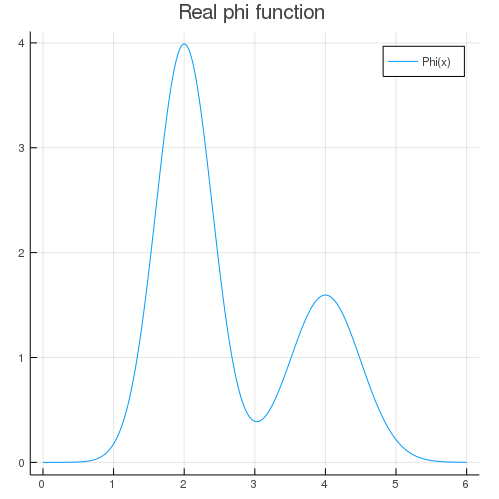

In [2]:
using Plots
plotly()
gr(size=(500,500), html_output_format=:png)

a = 0
b = 6.

function phi(x::Real)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5
    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))
myplot = plot(x, phi.(x), title="Real phi function",label=["Phi(x)"])
# savefig("real_phi.png")

In [3]:
using QuadGK
kernel_name = "rectangular"
kernel(x::Real, y::Real) = getOpticsKernels(kernel_name)(x, y)

convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=30))
ftrue = convolution.(y)

sig = 0.1*ftrue + [0.01 for i = 1:Base.length(ftrue)]

using Compat, Random, Distributions
noise = []
Random.seed!(1234)
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end

f = ftrue + noise
plot(y, f, title="$(kernel_name) kernel",label=["f(y)"],seriestype=:scatter, yerr=sig)
savefig("integrated_$(kernel_name).png")

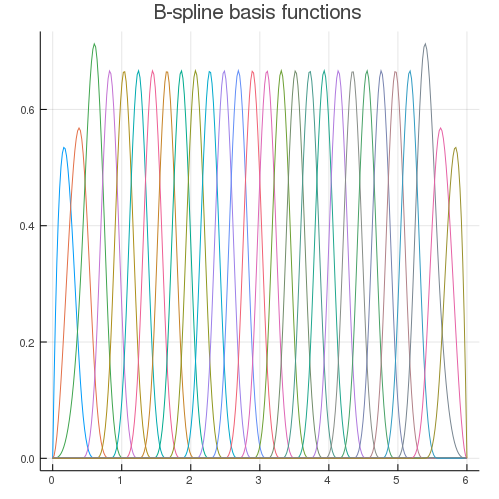

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:101


In [4]:
basis = CubicSplineBasis(y, "dirichlet")
p = plot()
for func in basis.basis_functions
    p = plot!(x, func.f.(x), title="B-spline basis functions", legend=false, show = true)
end
display(p)
# savefig("basis.png")

In [5]:
Omega = omega(basis, 2)
model = GaussErrorUnfolder(basis, [Omega], "EmpiricalBayes"; alphas=nothing, lower=[1e-8], higher=[10.], initial=[0.3])
println()

┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:55
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:159


In [6]:
result = solve(model, kernel, f, sig, y)
println()

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:192
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:85
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/ta_nyan/.julia/packages/BAT/YpnQS/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 conve

In [7]:
edit("../src/utils/other_utils.jl")

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


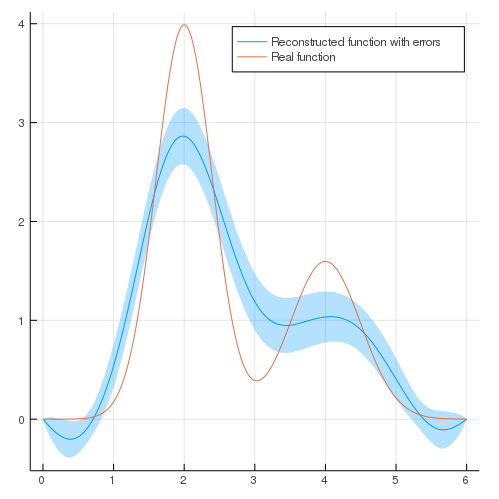

In [8]:
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3, label="Reconstructed function with errors")
plot!(x, phi.(x), label="Real function")
# savefig("reconstructed.png")